In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from pathlib import Path
import cv2
import math
from pyzbar.pyzbar import decode as pyzbar_decode

# 警告を非表示にする
import warnings
warnings.filterwarnings('ignore')

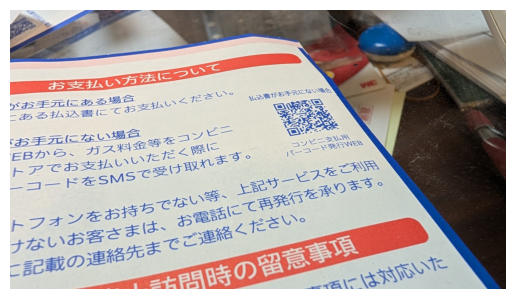

In [15]:
# image_path = Path("exmples/test_qr.png")
# image_path = Path("exmples/2025-04-26 21.24.27.jpg")
image_path = Path("exmples/2025-04-26 21.24.03.jpg")


img = cv2.imread(str(image_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# まずは表示
plt.axis('off')
plt.imshow(img)
plt.show()

Found 1 QR codes
QR code 1: https://reception.tokyo-gas.co.jp/tgcbpay


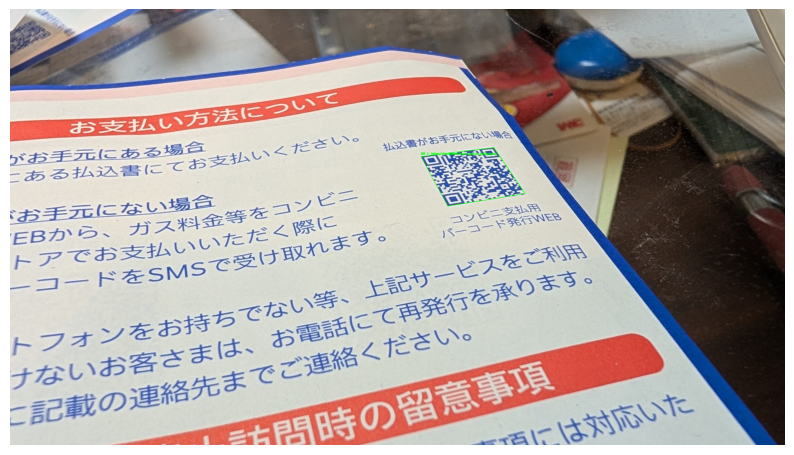

In [16]:
# Add this new cell to detect and decode multiple QR codes
detector = cv2.QRCodeDetector()
# detectAndDecodeMulti returns (retval, decoded_info, points, straight_qrcode)
retval, decoded_info, points, straight_qrcode = detector.detectAndDecodeMulti(img)

if retval:
    print(f"Found {len(decoded_info)} QR codes")
    
    # Create a copy of the image to draw on
    img_with_qr = img.copy()
    
    # Process each QR code
    for i, (info, pts) in enumerate(zip(decoded_info, points)):
        # Convert points to integer format
        pts = pts.astype(np.int32)
        
        # Draw the QR code boundary
        cv2.polylines(img_with_qr, [pts], True, (0, 255, 0), 2)
        
        # Add the decoded information
        x, y = pts[0][0], pts[0][1]
        cv2.putText(img_with_qr, f"QR {i+1}: {info}", (x, y-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        print(f"QR code {i+1}: {info}")
    
    # Display the image with QR codes highlighted
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img_with_qr)
    plt.show()
else:
    print("No QR codes detected")

QR code 1 average side length: 344.18 pixels
QR code 1 center: (2403.12, 868.35)


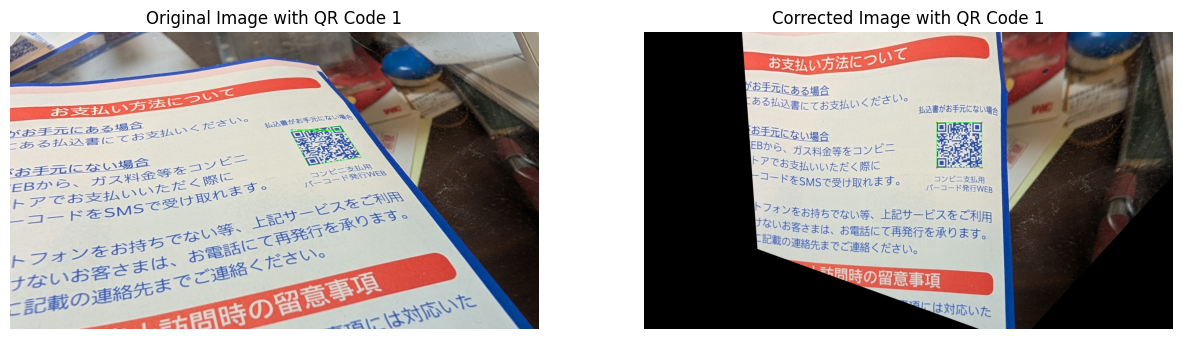

QR Code 1 Content: https://reception.tokyo-gas.co.jp/tgcbpay


In [20]:
# 画像全体に透視変換を適用して、QRコードを正面から見えるようにする
if retval and len(points) > 0:
    for i, pts in enumerate(points):
        # 入力点はshapeが(4, 1, 2)の形式になっているため、(4, 2)に変換する必要がある
        src_pts = pts.reshape(4, 2).astype(np.float32)
        
        # 元画像のサイズを取得
        original_height, original_width = img.shape[:2]
        
        # QRコードの辺の長さを計算
        side_lengths = []
        for j in range(4):
            p1 = src_pts[j]
            p2 = src_pts[(j+1) % 4]
            side_lengths.append(np.sqrt(((p2[0] - p1[0]) ** 2) + ((p2[1] - p1[1]) ** 2)))
        
        avg_side_length = np.mean(side_lengths)
        print(f"QR code {i+1} average side length: {avg_side_length:.2f} pixels")
        
        # QRコードの中心を計算
        center_x = np.mean(src_pts[:, 0])
        center_y = np.mean(src_pts[:, 1])
        print(f"QR code {i+1} center: ({center_x:.2f}, {center_y:.2f})")
        
        # 理想的な正方形のQRコードの座標を計算
        half_side = avg_side_length / 2
        ideal_qr_points = np.array([
            [center_x - half_side, center_y - half_side],  # 左上
            [center_x + half_side, center_y - half_side],  # 右上
            [center_x + half_side, center_y + half_side],  # 右下
            [center_x - half_side, center_y + half_side]   # 左下
        ], dtype=np.float32)
        
        # 透視変換の行列を計算
        perspective_matrix = cv2.getPerspectiveTransform(src_pts, ideal_qr_points)
        
        # 画像全体に透視変換を適用
        corrected_img = cv2.warpPerspective(img, perspective_matrix, (original_width, original_height))
        
        # 理想的なQRコードの位置を描画（確認用）
        img_with_ideal_points = corrected_img.copy()
        for j, point in enumerate(ideal_qr_points):
            x, y = point
            cv2.circle(img_with_ideal_points, (int(x), int(y)), 5, (255, 0, 0), -1)
            next_point = ideal_qr_points[(j+1) % 4]
            cv2.line(img_with_ideal_points, 
                     (int(x), int(y)), 
                     (int(next_point[0]), int(next_point[1])), 
                     (0, 255, 0), 2)
        
        # 結果の表示
        plt.figure(figsize=(15, 8))
        plt.subplot(1, 2, 1)
        plt.title(f"Original Image with QR Code {i+1}")
        plt.axis('off')
        plt.imshow(img_with_qr)
        
        plt.subplot(1, 2, 2)
        plt.title(f"Corrected Image with QR Code {i+1}")
        plt.axis('off')
        plt.imshow(img_with_ideal_points)
        plt.show()
        
        print(f"QR Code {i+1} Content: {decoded_info[i]}")
else:
    print("No QR codes detected for perspective transformation")